In [77]:
using NowcastLSTM, Plots, Statistics
pd = pyimport("pandas")
dill = pyimport("dill")
LSTM = pyimport("nowcast_lstm.LSTM").LSTM;

# Basic model usage
**\*note*** the model assumes stationary, seasonally adjusted series. So make sure required transformations are already performed by this point.
<br><br>
Data should be a dataframe with rows of the highest granularity of data and a date column. For example, predicting a yearly variable with monthly, quarterly, and yearly features should have a monthly dataframe. Quarterly variables should be represented as a single value during the period, with missings (`missing`) in between. E.g. Q1 data would be `missing` for January, `missing` for February, the value for March, etc. Yearly data would be `np.nan` for January - November, and the value for December.

In [2]:
# data read
data = CSV.File("data.csv", missingstrings=["NA"]) |> DataFrame
data = data[:, ["date", "x_jp", "x_world", "x_de", "x_uk", "ipi_cn", "x_vol_world2"]] # random subset of columns for simplicity
train_end_date = DateTime("2017-12-01") # training data through 2017
training = data[data.date .<= train_end_date,:];

In [4]:
# instantiating a model with 10 networks based on the previous 12 months with 50 train episodes. Defaults to mean-filling missing values. See documentation for more information on hyper-parameters.
# make sure to pass JuliaToPandas(df) to the function
model = LSTM(data=JuliaToPandas(training), target_variable="x_world", n_timesteps=12, n_models=10, train_episodes=50);

In [5]:
# train the model, quiet=true to suppress printing of training loss
model.train(quiet=true);

In [9]:
# getting predictions on the train set
train_preds = model.predict(model.data, only_actuals_obs=true) |> PandasToJulia; # only_actuals_obs=True to only get predictions where there are actuals present

In [38]:
# performance on the train set
plot(train_preds.date, train_preds.actuals, label="actuals")
plot!(train_preds.date, train_preds.predictions, label="predictions")

In [42]:
# getting predictions on the test set
test_preds = model.predict(JuliaToPandas(data), only_actuals_obs=true) |>
    PandasToJulia |> x-> 
    x[x.date .> train_end_date,:]; # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on

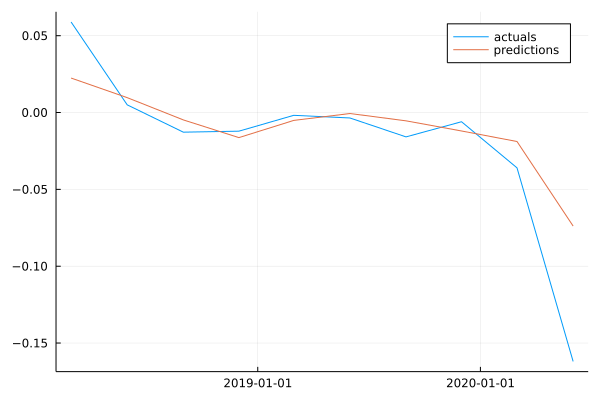

In [43]:
# performance on the test set
plot(test_preds.date, test_preds.actuals, label="actuals")
plot!(test_preds.date, test_preds.predictions, label="predictions")

In [45]:
# saving a trained model
dill.dump(model, py"open"("trained_model.pkl", mode="wb"))

In [47]:
# loading a trained model
trained_model = dill.load(py"open"("trained_model.pkl", "rb", -1));

# Realistic model evaluation scenario
The test set above assumes full data for each test observation, this is rarely the case with economic data. The process below outlines how to check the performance of the model on different data vintages, i.e. how the data would have looked at various points in time leading up to the prediction period.

In [49]:
# data setup
data = CSV.File("data.csv", missingstrings=["NA"]) |> DataFrame
data = data[:, ["date", "x_jp", "x_world", "x_de", "x_uk", "ipi_cn", "x_vol_world2"]] # random subset of columns for simplicity
train_end_date = DateTime("2017-12-01") # training data through 2017
training = data[data.date .<= train_end_date,:];
target = "x_world";

### pub_lags
This is a vector of dimensions 1 x n_features. I.e. the number of independent variables in the model, this means NOT including the target variable. So for a model with a 200 x 10 dataframe, with 200 observations and 10 columns, the pub_lags vector should have 9 entries, one for each variable less the target column.
<br><br>
Its function is to provide the publication lag/schedule for each series to be able to generate data vintages via the `gen_ragged_X` function. The contents should therefore be the number of periods of lag each series experiences when published. For example, if there are three independent variables in a monthly model, GDP, exports, and the business confidence index, and they are published with a 3, 2, and 1 month lag, respectively, the lag vector should read `[3,2,1]`, or in whatever order the columns are in the original dataframe. If the target period is June, values with a lag of 2 are available until April. A value of 1 means values are available to May. A lag value of 0 means that if we are in June, June values are available. 
<br><br>
The units of the lag is the units of the original dataframe, i.e. the highest granularity of data. The monthly example above should then be extrapolated for the case of e.g. daily or quarterly data.

In [65]:
# example publication lags. Means x_jp comes out 1 month later, x_de 0 months later, x_uk 2 months later, ipi_cn 3 months later, x_vol_world2 3 months later
pub_lags = [1, 0, 2, 3, 3];

In [52]:
# model instantiation and training
model = LSTM(JuliaToPandas(training), target, n_timesteps=12, n_models=10)
model.train(quiet=true)

### model assessment on vintages
The first testing example in this notebook made predictions on full datasets, i.e as if the lags for all variables was 0. This is an unrealistic scenario, so a better evaluation of a nowcasting model's performance is testing it on incomplete datasets that reflect real data publication conditions. The code below therefore uses the `pub_lags` vector and the `ragged_preds` function to create vintage datasets to test on. The below example will find performance of the model as if predictions were made 1, 2, and 3 months before the target period, in the target period, and 1 month after the target period. The appropriate prediction periods should be chosen as relevant for the use case of the nowcast. Testing continues after the target period because of publication lags. If we are nowcasting Q2 numbers and are in June, that does not mean that we have full data for June. Some figures from Q2 months may not come out until July or August, therefore the testing on vintages past the target period.

### ragged_preds
This function creates data vintages using a publication schedule, `pub_lags` vector, explained above, then generates predictions on these ragged datasets. The second parameter, `lag`, is the simulated period offset. It can be interpreted as the last period with full data relative to the target period. If we are nowcasting Q2, i.e. June, a lag of 0 simulates being in June. I.e. June is the last month with full data (for variables with lag 0). A lag of -1 simulates being in May, where May is the last full month. A lag of 1 simulates being in July, where variables with a lag of 1 now have June data as well. How many missings will be generated for a series can be calculated with `-1*(lag - variable_pub_lag)`. E.g. we set the lagged period to -2 months back, and the variable has a 1 month publication lag, `-1*(-2-1)=3`, so the last three months will be set to missing. The `data` parameter should be passed the dataset to predict, if different from the dataset the model was trained on. 
<br><br>
**note** if `"ARMA"` is chosen for `fill_ragged_edges_func`, `ragged_preds` will take significantly longer to calculate, as ARMA models have to be fit on every observation's data vintages.
<br><br>
Generally we should expect to see evaluation metrics get better the further ahead in time we move, as more data is available.

In [87]:
# performance on a single vintage, 2 months back of target period
lag = -2
test_preds = model.ragged_preds(pub_lags, lag, data=JuliaToPandas(data)) |>
    PandasToJulia |> x->
    x[x.date .> train_end_date, :] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on

# different evaluation metrics
RMSE = (test_preds.actuals - test_preds.predictions).^2 |> mean |> sqrt
MAE = (test_preds.actuals - test_preds.predictions) .|> abs |> mean

println("RMSE: $(round(RMSE, digits=4))")
println("MAE: $(round(MAE, digits=4))")

RMSE: 0.0235
MAE: 0.0199


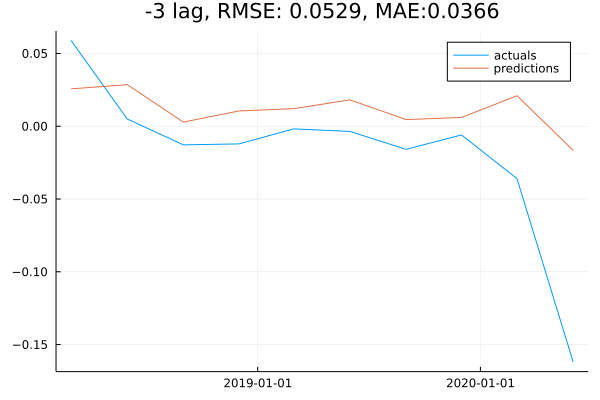

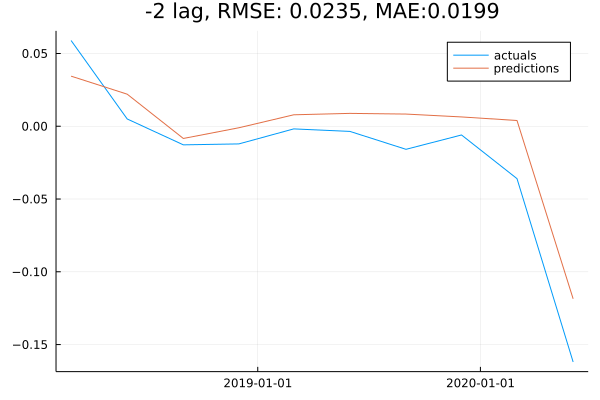

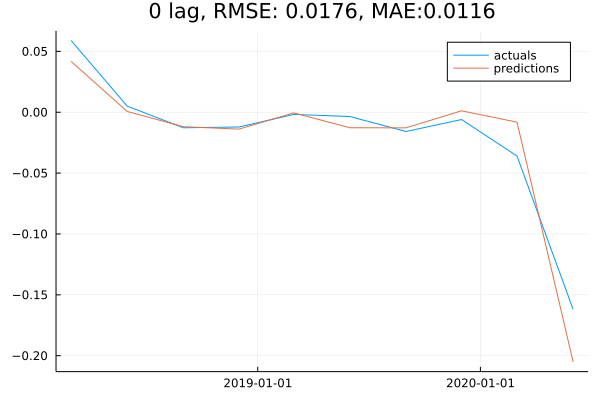

In [98]:
# visualization of performance over time, to see how performance develops
for lag in [-3, -2, -1, 0, 1] # 3 months back, 2 months back, 1 month back, month-of, 1 month ahead vintages
    test_preds = model.ragged_preds(pub_lags, lag, data=JuliaToPandas(data))|> 
        PandasToJulia |> x->
        x[x.date .> train_end_date, :] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on
    
    # different evaluation metrics
    RMSE = (test_preds.actuals - test_preds.predictions).^2 |> mean |> sqrt
    MAE = (test_preds.actuals - test_preds.predictions) .|> abs |> mean

    plot(test_preds.date, test_preds.actuals, label="actuals", title="$lag lag, RMSE: $(round(RMSE,digits=4)), MAE:$(round(MAE,digits=4))")
    plot!(test_preds.date, test_preds.predictions, label="predictions") |>
       display
end

# Different filling NA options
See the Python Jupyter Notebook for more information on this. In short, you can use any n->1 function (mean, median, etc.), or ARMA filling for ragged edges.

# Generating news / causal inference
The library provides a means of getting some causal inference on the change in the LSTM's outputs as new data are released, similar in concept to the [Fed's nowcasts](https://www.newyorkfed.org/research/policy/nowcast.html), which use dynamic factor models. Given an old and a new data release, the model's predictions will change. The method of generating each variable's contribution to this change is the following: for each column with new data, that data is held out of the latest dataset, then predictions are gotten. The difference between this prediction and the prediction with the full new dataset is considered this variable's contribution to the change in prediction. The process is repeated for all variables, and finally the process is run for the new dataset, but with all data that was missing in the old dataset missing as well. In this way, the contribution of data revisions can be ascertained. These contributions are the "news" column of the "news" dataframe output by the function. These are then scaled so that their sum equals the actual difference between old and new predictions. In most cases, this scaling factor, the "holdout_discrepency" of the function output, should be close to 1.

In [168]:
model = LSTM(JuliaToPandas(training), target, n_timesteps=12, n_models=1, optimizer=torch.optim.Adam, criterion=torch.nn.MSELoss())
model.train(quiet=true)

In [120]:
train_end_date = DateTime("2017-12-01") # training data through 2017
training = data[data.date .<= train_end_date,:]
model = LSTM(JuliaToPandas(training), target, n_timesteps=12, n_models=1)
model.train(quiet=true);

In [125]:
# new data is our latest dataset
new_data = copy(data)
# old data is our previous dataset
old_data = copy(data)
old_data[old_data.date .>= DateTime("2020-09-01"), ["x_jp", "x_de"]] .= missing
old_data[old_data.date .== DateTime("2020-08-01"), ["x_jp"]] .= 0.062;

Our old data (e.g. last week's data) didn't have data for x_de or x_jp for September 2020, while it had a higher value for x_jp in August 2020, which was revised downwards in the latest data. Make sure both datasets have the target variable in them, add the time periods necessary (with missings for all variables) if they are missing from one or the other dataset.

In [131]:
old_data |> x-> last(x, 5)

5×7 DataFrame
 Row │ date        x_jp             x_world   x_de             x_uk            ⋯
     │ Date        Float64?         Float64?  Float64?         Float64?        ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2020-07-01        0.0693431   missing        0.0697038        0.0632194 ⋯
   2 │ 2020-08-01        0.062       missing        0.0614121        0.111469
   3 │ 2020-09-01  missing           missing  missing               -0.0505648
   4 │ 2020-10-01  missing           missing  missing          missing
   5 │ 2020-11-01  missing           missing  missing          missing         ⋯
                                                               2 columns omitted

Our new data has new information, so new data were released

In [132]:
new_data |> x-> last(x, 5)

5×7 DataFrame
 Row │ date        x_jp             x_world   x_de             x_uk            ⋯
     │ Date        Float64?         Float64?  Float64?         Float64?        ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2020-07-01        0.0693431   missing        0.0697038        0.0632194 ⋯
   2 │ 2020-08-01        0.0570472   missing        0.0614121        0.111469
   3 │ 2020-09-01        0.0386996   missing        0.0260398       -0.0505648
   4 │ 2020-10-01        0.0291901   missing  missing          missing
   5 │ 2020-11-01  missing           missing  missing          missing         ⋯
                                                               2 columns omitted

We can run the .gen_news function to see the impact of these changes on the model's prediction

In [134]:
news = model.gen_news("2020-09-01", JuliaToPandas(old_data), JuliaToPandas(new_data))
news["news"] |> PandasToJulia

3×3 DataFrame
 Row │ column     news          scaled_news  
     │ String     Float64       Float64      
─────┼───────────────────────────────────────
   1 │ x_jp        0.0013134     0.00134165
   2 │ x_de        0.0012515     0.00127842
   3 │ revisions  -0.000328623  -0.000335693

We can also get the old prediction and the new prediction, as well as the holdout discrepency from the "news" dictionary object

In [135]:
news

Dict{Any, Any} with 4 entries:
  "news"                => PyObject       column      news  scaled_news…
  "new_pred"            => 0.125853
  "old_pred"            => 0.123568
  "holdout_discrepency" => 0.978937

The sum of the "scaled_news" column should sum to exactly the difference between the old and new predictions

In [143]:
println("Sum of the (unscaled) news column: $(round(sum(PandasToJulia(news["news"]).news), digits=6))")
println("Sum of the scaled_news column: $(round(sum(PandasToJulia(news["news"]).scaled_news), digits=6))")
println("Difference between old and new predictions: $(round(news["new_pred"] - news["old_pred"], digits=6))")

Sum of the (unscaled) news column: 0.002236
Sum of the scaled_news column: 0.002284
Difference between old and new predictions: 0.002284
